In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint
from scipy.integrate import quad
import seaborn as sns
from matplotlib import rcParams
from scipy.interpolate import InterpolatedUnivariateSpline
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})




π = np.pi
G = 4.4959e-15            #in units of M☉^-1 pc^3 yr^-2
c = 0.3068                #in units of pc yr^-1
ρ_eq = 3.1812e3           #in units of M☉ pc^-3 with ρ_eq=2.15368e-16 kg m^-3
t = 13.78e9               #in units of yrs corresponding to t_0=13.78Gyr
yr = 3.154e7              # in units of seconds
pc = 3.0857e16            # in meters
yr = 3.154e7              # in units of seconds
t_eq = 1.59246e12/yr      # in units of seconds
t_m = 5e9             #in units of yr 
σ_eq = 0.005
ρ_m  = 4e19                #ρ_m=4e19 M☉ Gpc^-3




m1 = np.geomspace(1, 1e5, 10)
m2 = np.geomspace(1e-4, 10, 10)

m_1_list = m1.tolist()
m_2_list = m2.tolist()


Δ_1_list = np.zeros(len(m_1_list))
Δ_2_list = np.zeros(len(m_2_list))



dm = (m_1_list[0] -  m_2_list[0])/2 

for i, (m_1, m_2) in enumerate(zip(m_1_list, m_2_list)):
    Δ_1_list[i] = Δ_2_list[i] = (m_1 + dm)  - (m_2 - dm)
    
    


In [4]:
# Merger Rate calculations for IMRIPY systems assuming that the DM halos are intact in the merging process.


file = np.load('tmofj0.npz')
ji_ref_list = file['arr_0']
tm_ref_list = file['arr_1']

print("tm_ref = ", tm_ref_list)
beta = 0.75
gamma  =  0.65
delta = -0.89
a_i_ref = (1e4 * 0.04606)   # in units of pc
m1_ref = 1      # in units of solar mass.
m2_ref = 1e-3   # in units of solar mass.



g =  InterpolatedUnivariateSpline(tm_ref_list, ji_ref_list, ext = 2) # j_i = g(t_m)

g_prime = g.derivative()




λ_0 = 4

def s(λ_0): # S_dec of the binary decouple.
    return ((0.03095*λ_0 + 0.3425)*λ_0)
    
def t(λ_0): 
    return ((np.sqrt(3/(8*π*G*ρ_eq)))*(((2/3)*(s(λ_0)-2)*np.sqrt(s(λ_0)+1))+(4/3)))
    

def Merger_imripy(m_1,m_2,Δ_1,Δ_2):
    
    def ρ_bar(m):
        return ((ρ_eq/2)*(t_eq**(3/2))*((2*G*m)**(3/4))) 
    
    def M_halo(m,λ_0):
        return (((16*π)/3)*ρ_bar(m)*((2*G*m*(t(λ_0)**2))**(1/4)))
    
    def M(m,λ_0):
        return (m + M_halo(m,λ_0))
    
    def M_binary_initial(m_1,m_2, λ_0):
        return (m_1 + m_2 + M_halo(m_1,λ_0) + M_halo(m_2,λ_0))
      
    def f_(m):
        return f*P(m)
    
    def f_b(m_1,m_2):
        return  f_(m_1)+f_(m_2)
    
    def D(λ_0):
        return ( 1 + 0.4440 * λ_0)/ np.sqrt(1 + 0.0583 * λ_0)
    
    X=np.geomspace(1e-2, 1e10*pc, 1000000)
    
    def j_X(m_1, m_2, Δ_1, Δ_2, X):
        return 0.4045 * np.sqrt(f**2 + 1.2005 * (σ_eq**2))  * np.sqrt((m_1 + m_2)/M_binary_initial(m_1,m_2, λ_0)) * D(λ_0) * (X/(f_b(m_1,m_2) * np.sqrt(Δ_1*Δ_2)))
    
    
    def PDF(m):
        return (P(m)/m)

    I = quad(PDF, 5, np.inf)     # Taking limits of the PBH mass from 5 M☉ to 100 M☉ instead of 
                                 # 0 to infinity.
    
    n_T = f*ρ_eq*I[0]            #n_T=f*ρ_eq∫(P(m)/m)*dm 
   
    def x̄(m_1,m_2,Δ_1,Δ_2):
        return (((3*(m_1 + m_2))/(8*π*ρ_eq*f_b(m_1,m_2)*np.sqrt(Δ_1*Δ_2)))**(1/3))
    
   
    def λ(m_1,m_2,Δ_1,Δ_2):
        return (8*π*ρ_eq*(x̄(m_1,m_2,Δ_1,Δ_2)**3))/(3*(m_1 + m_2))

    def a_initial(m_1,m_2,Δ_1,Δ_2, X):  # for x = x_bar 
        return (0.0977*λ(m_1,m_2,Δ_1,Δ_2) + 0.0057*(λ(m_1,m_2,Δ_1,Δ_2)**2)) * x̄(m_1,m_2,Δ_1,Δ_2) * (X**(1/3))
    
    
    def C(m_1,m_2,Δ_1,Δ_2, X):
        return ((a_initial(m_1,m_2,Δ_1,Δ_2, X)/a_i_ref)**(beta)) * ((m_1/ m1_ref)**(gamma)) * ((m_2/m2_ref)**(delta))

    
    def j_i(m_1,m_2,Δ_1,Δ_2, X):
        return  g(t_m/C(m_1,m_2,Δ_1,Δ_2, X))
    
    def j_i_prime(m_1,m_2,Δ_1,Δ_2, X):
        return  g_prime(t_m/C(m_1,m_2,Δ_1,Δ_2, X))
    
    
    def γ_X(m_1,m_2,Δ_1,Δ_2, X):    
        return j_i(m_1,m_2,Δ_1,Δ_2, X)/ j_X(m_1, m_2, Δ_1, Δ_2, X)

    def integrand(m_1,m_2,Δ_1,Δ_2, X):
        return j_i_prime(m_1,m_2,Δ_1,Δ_2, X) * (1/j_i(m_1,m_2,Δ_1,Δ_2, X)) * ((γ_X(m_1,m_2,Δ_1,Δ_2, X)**2)/ ((1 + (γ_X(m_1,m_2,Δ_1,Δ_2, X)**2))**(3/2))) * np.exp(- X * ((4*π)/3) * (x̄(m_1,m_2,Δ_1,Δ_2)**3) * n_T)
    
    
        
    return  (ρ_m/2) * (((f**2)* (m_1 + m_2))/(f_b(m_1,m_2)*np.sqrt(Δ_1*Δ_2))) * np.minimum((P(m_1)*Δ_1)/m_1, (P(m_2)*Δ_2)/m_2) * ((P(m_1)*Δ_1)/m_1 + (P(m_2)*Δ_2)/m_2) *   (np.trapz(integrand(m_1,m_2,Δ_1,Δ_2, X),X))


tm_ref =  [3.91015753e+09 4.08858133e+09 4.26884955e+09 4.45001680e+09
 4.63104113e+09 4.81079854e+09 4.98810012e+09 5.16172945e+09
 5.33046628e+09 5.49313199e+09 5.64862217e+09 5.79595804e+09
 5.93431562e+09 6.06305781e+09 6.18176281e+09 6.29023284e+09
 6.38849564e+09 6.47679739e+09 6.55558602e+09 6.62548772e+09
 6.68728670e+09 6.74190205e+09 6.79037578e+09 6.83387361e+09
 6.87370944e+09 6.91140436e+09 6.94878607e+09 6.98822757e+09
 7.03295318e+09 7.08757120e+09 7.15873913e+09 7.25577420e+09
 7.39070598e+09 7.57725202e+09 7.82939991e+09 8.16201907e+09
 8.59468001e+09 9.15608821e+09 9.88572575e+09 1.08331340e+10]


In [5]:
# Calculation of the 2D merger rate for Powerlaw PBH mass distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2.


Merger_imripy_PWR = np.zeros((10, 10))



for i in range(10):
    for j in range(10):
        
        f_pbh = 4.3e-3
        f = 0.85*f_pbh
        
          
        def P(m): #Powerlaw PBH mass distribution
            α = 1.6
            M = 5     #in units of M☉
            return ((α-1)/M) * ((m/M)**(-α))

        if i==j:
            Merger_imripy_PWR[i,j] = 0.5 * Merger_imripy(m_1_list[i], m_2_list[j], Δ_1_list[i], Δ_2_list[j])
            
        else:
            Merger_imripy_PWR[i,j] = Merger_imripy(m_1_list[i], m_2_list[j], Δ_1_list[i], Δ_2_list[j])   
    
        
np.save("Merger_imripy_PWR", Merger_imripy_PWR)



ValueError: Found x value not in the domain

In [22]:
# Calculation of the 2D merger rate for Log-Normal PBH mass Distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2.


Merger_imripy_LogNormal = np.zeros((10, 10))


for i in range(10):
    for j in range(10):
        
        f_pbh = 3.7e-3
        f = 0.85*f_pbh 
        
        def P(m):               #Log-Normal PBH mass Distribution
            σ = 0.6
            m_c = 15               #in units of M☉
            return  (1/(σ * m * math.sqrt(2*π))) * math.exp(-((math.log(m/m_c))**2)/(2*(σ**2)))

        if i==j:
            Merger_imripy_LogNormal[i, j] = 0.5 * Merger_imripy(m_1_list[i], m_2_list[j], Δ_1_list[i], Δ_2_list[j], j_i_list[i])
            
        else:
            Merger_imripy_LogNormal[i, j] = Merger_imripy(m_1_list[i], m_2_list[j], Δ_1_list[i], Δ_2_list[j], j_i_list[i])
            

np.save("Merger_imripy_LogNormal", Merger_imripy_LogNormal)

In [2]:
# Formatting x and y-axis labels.

def sciformat_3(x):
    n = np.floor(np.log10(x))
    m = x*(10.0**(-n))
    str1 = ""
    if (n in [0, 1]):
        return r'$%d$'%(x,)
    elif (m > 1.001):
        str1 = r'$%d \times ' % (m,)
        str2 = r'10^{%d}$' % n
    else:
        str2 = r'$10^{%d}$' % n
    return str1 + str2

xlabel_list = np.zeros(len(m_1_list), dtype ='U100')
ylabel_list = np.zeros(len(m_2_list), dtype ='U100')

for i, x in enumerate(m_1_list):
    xlabel_list[i] = sciformat_3(x)
    
for i, x in enumerate(m_2_list):
    ylabel_list[i] = sciformat_3(x)

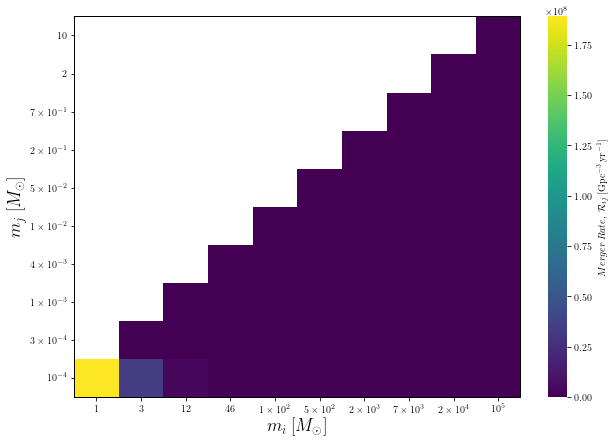

In [67]:
# Plot  for IMRIPY Merger rate using Power Law PBH mass function.

plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'



Merger_imripy_PWR = np.load('Merger_imripy_PWR.npy')

mask = np.tril(np.ones((10,10)), k=-1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax = plt.subplots(figsize=(10, 7))  



ax = sns.heatmap(Merger_imripy_PWR, mask = mask,  cmap = 'viridis', cbar = True, 
                 cbar_kws = {"shrink": 1,'label': '$Merger \: Rate, \: \mathcal{R}_{ij} \: [\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}]$'},
                  )

    

# make frame visible
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)
    



ax.set_xticklabels(xlabel_list)
ax.set_yticklabels(ylabel_list,rotation = 360)





ax.invert_yaxis()
plt.xlabel('$m_{i}\:[M_{\odot}]$', fontsize = 18)
plt.ylabel('$m_{j}\: [M_{\odot}]$', fontsize = 18)
plt.savefig('IMRIPYPWRLAW.pdf', bbox_inches = 'tight')
plt.show()     

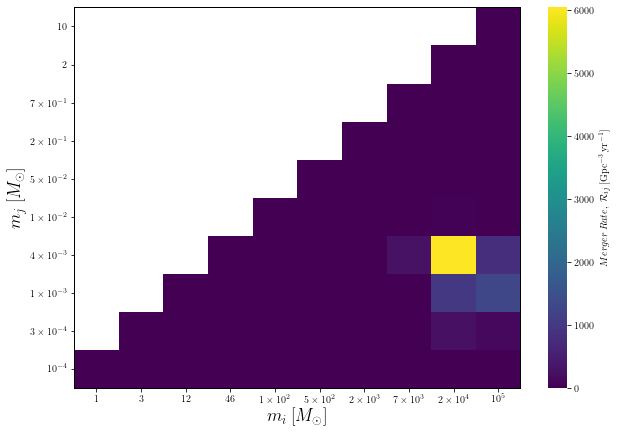

In [25]:
# Plot  for IMRIPY Merger rate using Lognormal PBH mass function.


plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'



Merger_imripy_LogNormal = np.load('Merger_imripy_LogNormal.npy')

mask_lognormal = np.tril(np.ones((10,10)), k=-1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax = plt.subplots(figsize=(10, 7))  



ax = sns.heatmap(Merger_imripy_LogNormal, mask = mask_lognormal,  cmap = 'viridis', cbar = True, 
                 cbar_kws = {"shrink": 1,'label': '$Merger \: Rate, \: \mathcal{R}_{ij} \: [\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}]$'},
                  )

    

# make frame visible
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)
    



ax.set_xticklabels(xlabel_list)
ax.set_yticklabels(ylabel_list,rotation = 360)



ax.invert_yaxis()
plt.xlabel('$m_{i}\:[M_{\odot}]$', fontsize = 18)
plt.ylabel('$m_{j}\: [M_{\odot}]$', fontsize = 18)
plt.savefig('IMRIPYLOGNRML.pdf', bbox_inches = 'tight')
plt.show()     

In [26]:
# Merger rate for IMRIPY system when they throw away all of the dark matter before merging.


λ_0=4
k = 22.5707
A=((ρ_eq**(4/3))*(G**3)*(k**7))/(c**5)


def s(λ_0): # S_dec of the binary decouple.
    return ((0.03095*λ_0 + 0.3425)*λ_0)
    
def t(λ_0): 
    return ((np.sqrt(3/(8*π*G*ρ_eq)))*(((2/3)*(s(λ_0)-2)*np.sqrt(s(λ_0)+1))+(4/3)))
    
a_i_by_x = (0.0977* λ_0 + 0.0057 * (λ_0**2))



def Merger_imripy_nohalo(m_1,m_2,Δ_1,Δ_2,λ_0,t_m):
    
    def ρ_bar(m):
        return ((ρ_eq/2)*(t_eq**(3/2))*((2*G*m)**(3/4))) 
    
    def M_halo(m,λ_0):
        return (((16*π)/3)*ρ_bar(m)*((2*G*m*(t(λ_0)**2))**(1/4)))
    
    def M(m,λ_0):
        return (m + M_halo(m,λ_0))
    
    def M_binary_initial(m_1,m_2, λ_0):
        return (m_1 + m_2 + M_halo(m_1,λ_0) + M_halo(m_2,λ_0))
      
    def f_(m):
        return f*P(m)
    
    def f_b(m_1,m_2):
        return  f_(m_1)+f_(m_2)
    
    def μ(m_1,m_2,Δ_1,Δ_2):
        return   (2 * m_1 * m_2 * f_b(m_1,m_2) * np.sqrt(Δ_1*Δ_2))/((m_1+m_2) * ((f_(m_2)*Δ_2 * m_1) + (f_(m_1)*Δ_1 * m_2)))

    
    #Schwarzchild Radius of the PBH.
    def r_s(m): 
        return ((2*G*m)/(c**2)) 


    #r_turnaround of the dark matter halos, eq.(5) in "WIMPs and stellar-mass primordial black holes are incompatible"
    def r_ta(m,λ_0): 
        return ((2*G*m*(t(λ_0)**2))**(1/3))


    # The binding energy, E_b of the dark matter halos calculated within r_s and r_ta for dark matter halo's density profile of ρ(r)∝ r^{-9/4}
    def E_b(m,s): 
        return ((16*π*G*ρ_bar(m)*m*(((r_ta(m,λ_0))**(-1/4))-((r_s(m))**(-1/4))))-((128/3)*G*(π**2)*(ρ_bar(m)**2)*(((r_ta(m,λ_0))**(1/2))-((r_s(m))**(1/2)))))
    
    def x(m_1,m_2,λ_0):
        return ((3 * (m_1 + m_2)* λ_0 ) /(8 * π * ρ_eq))**(1/3)
    
    def a_initial(m_1,m_2,λ_0):
        return a_i_by_x * x(m_1,m_2,λ_0)

    def beta(m_1,m_2,λ_0 ):
        return ((G*m_1*m_2)/((G*M(m_1,λ_0)*M(m_2,λ_0))-(2*a_initial(m_1,m_2,λ_0)*(E_b(m_1,λ_0)+E_b(m_2,λ_0)))))

    
    def reduced_mass_initial(m_1,m_2,λ_0):
        return (M(m_1,λ_0) * M(m_2,λ_0)) / (M(m_1,λ_0) + M(m_2,λ_0))
    
    def reduced_mass_final(m_1,m_2):
        return (m_1 * m_2)/(m_1 + m_2)
    
    
    def C(m_1,m_2, λ_0):
        return np.sqrt((reduced_mass_final(m_1,m_2) * m_1 * m_2)/ (reduced_mass_initial(m_1,m_2,λ_0 ) * M(m_1,λ_0) * M(m_2,λ_0))) 
    
    
    def B(m_1,m_2,Δ_1,Δ_2):
        return (A**(1/7)) * ((m_1 * m_2 * t_m)**(1/7)) * C(m_1,m_2, λ_0) *  (M_binary_initial(m_1,m_2, λ_0)**(1/2)) *  ((m_1+m_2)**(-23/42)) * ((f_b(m_1,m_2))**(37/21))* ((f**2 + 1.2005*(σ_eq**2))**(-1/2)) * ((Δ_1*Δ_2)**(37/42)) * (beta(m_1,m_2,λ_0)**(-1/14))
    
    
    def D(m_1,m_2,Δ_1,Δ_2):
        return (B(m_1,m_2,Δ_1,Δ_2)**(21/37))/(f_b(m_1,m_2) * np.sqrt(Δ_1*Δ_2))  
    
    
    def γ_X(Y,m_1,m_2,Δ_1,Δ_2):      #eq.(12) in the notes.
        return ((((1 + 0.0583 * D(m_1,m_2,Δ_1,Δ_2) * (Y**(-21/37)))**(-1/14))/( 1 + 0.4440 * D(m_1,m_2,Δ_1,Δ_2) * (Y**(-21/37))))*Y)

    
    def PDF(m):
        return (P(m)/m)

    
    I = quad(PDF, 5, np.inf)  # Taking limits of the PBH mass from 5 M☉ to 100 M☉ instead of 
                               # 0 to infinity.
    
    n_T = f * ρ_eq * I[0]         #n_T=f*ρ_eq∫(P(m)/m)*dm 
   
    
    def x̄(m_1,m_2,Δ_1,Δ_2):
        return (((3*(m_1+m_2))/(8*π*ρ_eq*f_b(m_1,m_2)*np.sqrt(Δ_1*Δ_2)))**(1/3))
    
    
    Y=np.geomspace(1e-2,1e10*pc,1000000) 
    
    
    def integrand(Y,m_1,m_2,Δ_1,Δ_2):
        return (Y**(-58/37))   *  np.exp(-((4*π)/3)  * (x̄(m_1,m_2,Δ_1,Δ_2)**3) * n_T * ((Y/B(m_1,m_2,Δ_1,Δ_2))**(-21/37))) * ((γ_X(Y,m_1,m_2,Δ_1,Δ_2)**2)/ ((1 + (γ_X(Y,m_1,m_2,Δ_1,Δ_2)**2))**(3/2)))

    
    
    return (3/74) * (A**(3/37))  * ρ_m * (C(m_1,m_2, λ_0)**(21/37)) * (t_m ** (-34/37))* (f**2) *  ((f**2 + 1.2005*(σ_eq**2))**(-21/74)) *  ((m_1 * m_2)**(3/37)) * (M_binary_initial(m_1,m_2,λ_0)**(21/74)) *  ((m_1+m_2)**(51/74))* (beta(m_1,m_2,λ_0)**(-3/74)) * np.minimum((P(m_1)*Δ_1)/m_1, (P(m_2)*Δ_2)/m_2) * ((P(m_1)*Δ_1)/m_1 + (P(m_2)*Δ_2)/m_2)  * (np.trapz(integrand(Y,m_1,m_2,Δ_1,Δ_2),Y)) 


In [27]:
# Calculation of the 2D merger rate for Powerlaw PBH mass distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2.


Merger_imripy_nohalo_PWR = np.zeros((10, 10))


for i in range(10):
    for j in range(10):
        
        f_pbh = 4.3e-3
        f = 0.85 * f_pbh
        
          
        def P(m): #Powerlaw PBH mass distribution
            α = 1.6
            M = 5     #in units of M☉
            return ((α-1)/M) * ((m/M)**(-α))

        if i==j:
            Merger_imripy_nohalo_PWR[i,j] = 0.5*Merger_imripy_nohalo(m_1_list[i], m_2_list[j], Δ_1_list[i], Δ_2_list[j],λ_0, t_m)
            
        else:
            Merger_imripy_nohalo_PWR[i,j] = Merger_imripy_nohalo(m_1_list[i], m_2_list[j], Δ_1_list[i], Δ_2_list[j],λ_0, t_m)   
    
        
np.save("Merger_imripy_nohalo_PWR", Merger_imripy_nohalo_PWR)



In [28]:
# Calculation of the 2D merger rate for Log-Normal PBH mass Distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2.

Merger_imripy_nohalo_LOGNORMAL = np.zeros((10, 10))


for i in range(10):
    for j in range(10):
        
        f_pbh = 3.7e-3
        f = 0.85*f_pbh 
        
        def P(m):               #Log-Normal PBH mass Distribution
            σ = 0.6
            m_c = 15               #in units of M☉
            return  (1/(σ * m * math.sqrt(2*π))) * math.exp(-((math.log(m/m_c))**2)/(2*(σ**2)))

        if i==j:
            Merger_imripy_nohalo_LOGNORMAL[i, j] = 0.5 * Merger_imripy_nohalo(m_1_list[i], m_2_list[j], Δ_1_list[i], Δ_2_list[j], λ_0, t_m)
            
        else:
            Merger_imripy_nohalo_LOGNORMAL[i, j] = Merger_imripy_nohalo(m_1_list[i], m_2_list[j], Δ_1_list[i], Δ_2_list[j], λ_0, t_m)
            

np.save("Merger_imripy_nohalo_LOGNORMAL", Merger_imripy_nohalo_LOGNORMAL)

In [3]:
# Plot for IMRIPY merger rate using Power Law PBH mass function when all DM is thrown away before merger.

plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'


Merger_imripy_nohalo_PWR  = np.load('Merger_imripy_nohalo_PWR.npy')


mask = np.tril(np.ones((10,10)), k=-1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax = plt.subplots(figsize=(10, 7))  


ax = sns.heatmap(Merger_imripy_nohalo_PWR, mask = mask,  cmap = 'viridis', cbar = True, 
                 cbar_kws = {"shrink": 1,'label': '$Merger \: Rate, \: \mathcal{R}_{ij} \: [\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}]$'},
                  )

    

# make frame visible
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)
    


ax.set_xticklabels(xlabel_list)
ax.set_yticklabels(ylabel_list,rotation = 360)





ax.invert_yaxis()
plt.xlabel('$m_{i}\:[M_{\odot}]$', fontsize = 18)
plt.ylabel('$m_{j}\: [M_{\odot}]$', fontsize = 18)
plt.savefig('PWRLAW.pdf', bbox_inches = 'tight')
plt.show()     

FileNotFoundError: [Errno 2] No such file or directory: 'Merger_imripy_nohalo_PWR.npy'

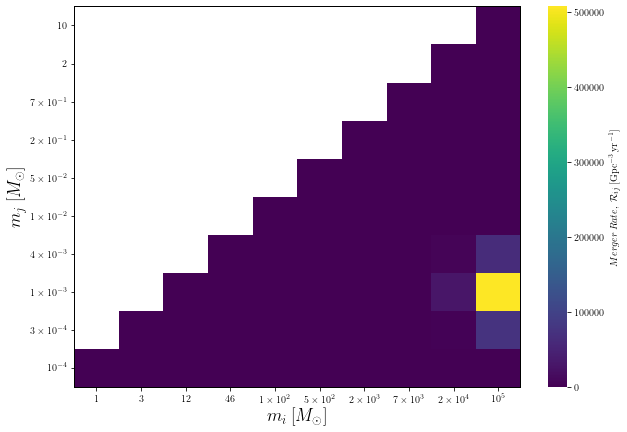

In [4]:
# Plot of IMRIPY Merger rate using Lognormal PBH mass function when all DM is thrown away before merger.

plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'


Merger_imripy_nohalo_LOGNORMAL  = np.load('Merger_imripy_nohalo_LOGNORMAL.npy')



mask_lognormal = np.tril(np.ones((10,10)), k=-1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax = plt.subplots(figsize=(10, 7))  



ax = sns.heatmap(Merger_imripy_nohalo_LOGNORMAL, mask = mask_lognormal,  cmap = 'viridis', cbar = True, 
                 cbar_kws = {"shrink": 1,'label': '$Merger \: Rate, \: \mathcal{R}_{ij} \: [\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}]$'},
                  )

    

# make frame visible
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)
    


ax.set_xticklabels(xlabel_list)
ax.set_yticklabels(ylabel_list,rotation = 360)



ax.invert_yaxis()
plt.xlabel('$m_{i}\:[M_{\odot}]$', fontsize = 18)
plt.ylabel('$m_{j}\: [M_{\odot}]$', fontsize = 18)
plt.savefig('LOGNRML.pdf', bbox_inches = 'tight')
plt.show()     